# Model

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

Files to upload: 
uni_final.csv and df_18_final.csv  
Path: Flatiron School > Capstone Project > Dog Licenses > data

This kind of model and dataset would lend itself well to a multivariate LSTM model. Let's just take an initial look at the scope of the categorical variables

In [ ]:
df_raw = pd.read_csv('raw_data.csv')
df_raw.head()

,ValidDate,LicenseType,Breed,Color,DogName,OwnerZip,ExpYear
0,2014-12-02 09:40:53,Dog Individual Neutered Male,COCKAPOO,BROWN,CHARLEY,15236,2015
1,2014-12-02 09:45:25,Dog Senior Citizen or Disability Neutered Male,GER SHEPHERD,BLACK/BROWN,TACODA,15238,2015
2,2014-12-02 09:47:55,Dog Individual Spayed Female,GER SHEPHERD,BLACK,CHARLY,15205,2015
3,2014-12-02 10:02:33,Dog Individual Spayed Female,LABRADOR RETRIEVER,BLACK,ABBEY,15143,2015
4,2014-12-02 10:05:50,Dog Individual Female,GER SHORTHAIR POINT,BROWN,CHARLEY,15228,2015


In [ ]:
print(len(df_raw['Breed']) + len(df_raw['Color']) + len(df_raw['DogName']) + len(df_raw['OwnerZip']))
#If we kepts columns 'as is' and did dummies, this is how many columns we would have

1146896


A multivariate model seems to be out of the scope of this project. However, an idea for future work would be to use an aggregate of a categorical variable (ie. total PitBulls per month) or a top 10 most popular of a variable to see if we could derive any unexpected insight. 

# Using an LSTM to predict on a single variable (sum of licenses per day)

In [ ]:
uni_final = pd.read_csv('/content/uni_final.csv')

In [ ]:
uni_final.head()

,ValidDate,Sum
0,2014-12-02,82
1,2014-12-03,232
2,2014-12-04,351
3,2014-12-05,163
4,2014-12-08,337


In [ ]:
uni_final.set_index('ValidDate', inplace = True)

In [ ]:
uni_final.head()

,Sum
ValidDate,
2014-12-02,82
2014-12-03,232
2014-12-04,351
2014-12-05,163
2014-12-08,337


In [ ]:
#Because I am only testing on one variable, should I still scale it? 
#Scale for sake of timely convergence

In [ ]:
scaler = MinMaxScaler()
uni_scaled = scaler.fit_transform(uni_final.values)

#Use series_to_supervise() function from Jason Brownlee via Machine Learning Mastery
#Use a lag of 1 to match SARIMA model 

In [ ]:
def series_to_supervise(data, n_in = 1, n_out = 1, dropnan = True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d' % (j+1)) for j in range(n_vars)]
    else: 
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  agg = pd.concat(cols, axis = 1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace = True)
  return agg

In [ ]:
uni_lstm = series_to_supervise(uni_scaled, 1, 1)
uni_lstm.head()

,var1(t-1),var1
1,0.013245,0.037474
2,0.037474,0.056695
3,0.056695,0.026329
4,0.026329,0.054434
5,0.054434,0.027298


# Fit data for LSTM model, split into train and test sets

In [ ]:
X = uni_lstm['var1(t-1)'].values
y = uni_lstm['var1'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541,) (541,) (232,) (232,)


# Build LSTM model and tune to lowest possible MSE 

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232,)


In [ ]:
#Build the LSTM model! 
now = datetime.datetime.now()
model = Sequential()
model.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'sgd', metrics = ['mse'])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 72, validation_data = (X_test, y_test), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/50
8/8 [==============================] - 0s 57ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 

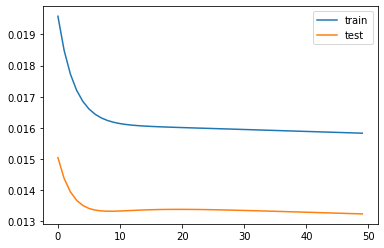

In [ ]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [ ]:
# Looks like it's converging before even 10 epochs

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 1, 1)
X_test.shape

(232, 1, 1)

In [ ]:
# Time to make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

mse = mean_squared_error(inv_y, inv_yhat)
print('MSE of prediction: ', np.round(mse, 2))

MSE of prediction:  507356.01


In [ ]:
# ARIMA model MSE = 145107.43, LSTM model MSE = 528370.14

In [ ]:
#Try to get the lowest MSE possible before trying to make a forecast.  

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
# Tune the model 
now = datetime.datetime.now()
model_tune = Sequential()
model_tune.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2])))
model_tune.add(Dense(50, activation = 'tanh'))
model_tune.add(Dense(35, activation = 'tanh'))
model_tune.add(Dense(20, activation = 'tanh'))
model_tune.add(Dense(1))
model_tune.compile(loss = 'mse', optimizer = 'sgd', metrics = ['mse'])

history_tune = model_tune.fit(X_train, y_train, epochs = 50, batch_size = 72, validation_data = (X_test, y_test), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/50
8/8 [==============================] - 0s 55ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 

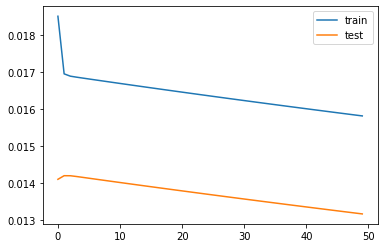

In [ ]:
plt.plot(history_tune.history['loss'], label = 'train')
plt.plot(history_tune.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [ ]:
#Still definitely overfitting, even more so now
# Original MSE: 0.0164 
# Tune MSE: 0.0153 
# Keep the 5 layers. Let's look at how to reduce the overfitting

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
yhat_tune = model_tune.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat_tune = np.concatenate((yhat_tune, X_test[:, 1:]), axis = 1)
inv_yhat_tune = scaler.inverse_transform(inv_yhat_tune)
inv_yhat_tune = inv_yhat_tune[:, 0]

y_test_tune = y_test.reshape((len(y_test), 1))
inv_y_tune = np.concatenate((y_test_tune, X_test[:, 1:]), axis = 1)
inv_y_tune = scaler.inverse_transform(inv_y_tune)
inv_y_tune = inv_y_tune[:, 0]

mse_tune = mean_squared_error(inv_y_tune, inv_yhat_tune)
print('MSE of tuned prediction: ', np.round(mse_tune, 2))

MSE of tuned prediction:  504718.73


In [ ]:
#LSTM model MSE = 528370.14
#Tune 1 = 461669.22

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
# Tune the model 
# Keep 5 layers, try dropouts and maybe an adam optimizer
now = datetime.datetime.now()
model_tune = Sequential()
model_tune.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2])))
model_tune.add(Dense(50, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(35, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(20, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(1))
model_tune.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_tune = model_tune.fit(X_train, y_train, epochs = 50, batch_size = 72, validation_data = (X_test, y_test), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/50
8/8 [==============================] - 0s 59ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 

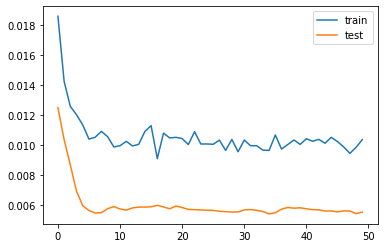

In [ ]:
plt.plot(history_tune.history['loss'], label = 'train')
plt.plot(history_tune.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [ ]:
# Original MSE: 0.0164
# Tune MSE: 0.0098 
# I may go ahead and attempt a forecast with this model and see what the MSE is

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
yhat_tune = model_tune.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat_tune = np.concatenate((yhat_tune, X_test[:, 1:]), axis = 1)
inv_yhat_tune = scaler.inverse_transform(inv_yhat_tune)
inv_yhat_tune = inv_yhat_tune[:, 0]

y_test_tune = y_test.reshape((len(y_test), 1))
inv_y_tune = np.concatenate((y_test_tune, X_test[:, 1:]), axis = 1)
inv_y_tune = scaler.inverse_transform(inv_y_tune)
inv_y_tune = inv_y_tune[:, 0]

mse_tune = mean_squared_error(inv_y_tune, inv_yhat_tune)
print('MSE of tuned prediction: ', np.round(mse_tune, 2))

MSE of tuned prediction:  212194.89


In [ ]:
#LSTM model MSE = 528370.14
#Tune 1 = 461669.22
#Tune 2 = 215734.43

In [ ]:
# Attempt a few more tuning measures, since this is not taking long to run. 
# Tune until LSTM < ARIMA 

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
# Try a relu activation to see what happens. 
# Train for 10 epochs, since it's converging well before 50.

now = datetime.datetime.now()
model_tune = Sequential()
model_tune.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2])))
model_tune.add(Dense(50, activation = 'relu'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(35, activation = 'relu'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(20, activation = 'relu'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(1))
model_tune.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_tune = model_tune.fit(X_train, y_train, epochs = 10, batch_size = 72, validation_data = (X_test, y_test), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/10
8/8 [==============================] - 0s 57ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 

In [ ]:
# Previous tune MSE: 0.0098
# Current tune MSE: 0.0114 
# Keep the tanh activation 

In [ ]:
yhat_tune = model_tune.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat_tune = np.concatenate((yhat_tune, X_test[:, 1:]), axis = 1)
inv_yhat_tune = scaler.inverse_transform(inv_yhat_tune)
inv_yhat_tune = inv_yhat_tune[:, 0]

y_test_tune = y_test.reshape((len(y_test), 1))
inv_y_tune = np.concatenate((y_test_tune, X_test[:, 1:]), axis = 1)
inv_y_tune = scaler.inverse_transform(inv_y_tune)
inv_y_tune = inv_y_tune[:, 0]

mse_tune = mean_squared_error(inv_y_tune, inv_yhat_tune)
print('MSE of tuned prediction: ', np.round(mse_tune, 2))

MSE of tuned prediction:  228306.43


In [ ]:
#LSTM model MSE = 528370.14
#Tune 1 = 461669.22
#Tune 2 = 215734.43
#Tune 3 = 226372.89

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
# Try changing batch size 
now = datetime.datetime.now()
model_tune = Sequential()
model_tune.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2])))
model_tune.add(Dense(50, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(35, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(20, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(1))
model_tune.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_tune = model_tune.fit(X_train, y_train, epochs = 10, batch_size = 20, validation_data = (X_test, y_test), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/10
28/28 [==============================] - 0s 18ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 2/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 3/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0

In [ ]:
# Previous tune MSE: 0.0098
# Current tune MSE: 0.0094
# Batch size did not make a significant difference 

In [ ]:
yhat_tune = model_tune.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat_tune = np.concatenate((yhat_tune, X_test[:, 1:]), axis = 1)
inv_yhat_tune = scaler.inverse_transform(inv_yhat_tune)
inv_yhat_tune = inv_yhat_tune[:, 0]

y_test_tune = y_test.reshape((len(y_test), 1))
inv_y_tune = np.concatenate((y_test_tune, X_test[:, 1:]), axis = 1)
inv_y_tune = scaler.inverse_transform(inv_y_tune)
inv_y_tune = inv_y_tune[:, 0]

mse_tune = mean_squared_error(inv_y_tune, inv_yhat_tune)
print('MSE of tuned prediction: ', np.round(mse_tune, 2))

MSE of tuned prediction:  245863.14


In [ ]:
#LSTM model MSE = 528370.14
#Tune 1 = 461669.22
#Tune 2 = 215734.43
#Tune 3 = 226372.89
#Tune 4 = 233653.45

#Keep tune 2

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(541, 1, 1) (541,) (232, 1, 1) (232, 1)


In [ ]:
now = datetime.datetime.now()
model_tune = Sequential()
model_tune.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2])))
model_tune.add(Dense(50, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(35, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(20, activation = 'tanh'))
model_tune.add(Dropout(0.3))
model_tune.add(Dense(1))
model_tune.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_tune = model_tune.fit(X_train, y_train, epochs = 10, batch_size = 72, validation_data = (X_test, y_test), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/10
8/8 [==============================] - 0s 56ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 

In [ ]:
# Increase lags. It's not a direct comparison to ARIMA, but it will most likely increase the accuracy of the prediction 

In [ ]:
three_lag = series_to_supervise(uni_scaled, 3, 1)
three_lag.head()

,var1(t-3),var1(t-2),var1(t-1),var1
3,0.013245,0.037474,0.056695,0.026329
4,0.037474,0.056695,0.026329,0.054434
5,0.056695,0.026329,0.054434,0.027298
6,0.026329,0.054434,0.027298,0.017606
7,0.054434,0.027298,0.017606,0.019706


In [ ]:
X_3 = three_lag.drop(['var1'], axis = 1).values
y_3 = three_lag['var1'].values

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.3, random_state = 42)

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (1), features (1)
X_train_3 = X_train_3.reshape((X_train_3.shape[0], 3, 1))
X_test_3 = X_test_3.reshape((X_test.shape[0], 3, 1))
print(X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape)

(539, 3, 1) (539,) (232, 3, 1) (232,)


In [ ]:
now = datetime.datetime.now()
model_3 = Sequential()
model_3.add(LSTM(50, input_shape = (X_train_3.shape[1], X_train_3.shape[2])))
model_3.add(Dense(50, activation = 'tanh'))
model_3.add(Dropout(0.3))
model_3.add(Dense(35, activation = 'tanh'))
model_3.add(Dropout(0.3))
model_3.add(Dense(20, activation = 'tanh'))
model_3.add(Dropout(0.3))
model_3.add(Dense(1))
model_3.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_3 = model_3.fit(X_train_3, y_train_3, epochs = 10, batch_size = 72, validation_data = (X_test_3, y_test_3), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now

Epoch 1/10
8/8 [==============================] - 0s 58ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 8/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 

In [ ]:
#Single lag MSE: 0.0094
#3 day lag MSE: 0.0066
# I think I'll take a win where I can get it. There's always the opportunity to keep tuning, but I think this is where i'll call it for this project. 
# Now for a forecast.

In [ ]:
# ARIMA model MSE = 145107.43, tuned LSTM model MSE = 217163.67

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (3), features (1)
X_train_3 = X_train_3.reshape((X_train_3.shape[0], 3, 1))
X_test_3 = X_test_3.reshape((X_test.shape[0], 3, 1))
print(X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape)

(539, 3, 1) (539,) (232, 3, 1) (232,)


In [ ]:
yhat_3 = model_3.predict(X_test_3)
X_test_3 = X_test_3.reshape((X_test_3.shape[0], 3))
inv_yhat_3 = np.concatenate((yhat_3, X_test_3[:, 1:]), axis = 1)
inv_yhat_3 = scaler.inverse_transform(inv_yhat_3)
inv_yhat_3 = inv_yhat_3[:, 0]

y_test_3 = y_test_3.reshape((len(y_test_3), 1))
inv_y_3 = np.concatenate((y_test_3, X_test_3[:, 1:]), axis = 1)
inv_y_3 = scaler.inverse_transform(inv_y_3)
inv_y_3 = inv_y_3[:, 0]

mse_3 = mean_squared_error(inv_y_3, inv_yhat_3)
print('MSE of Lag 3 prediction: ', np.round(mse_3, 2))

MSE of Lag 3 prediction:  288473.52


In [ ]:
#Well that didn't go as expected... 
# ARIMA model MSE = 145107.43, tuned LSTM model MSE = 217163.67, Lag 3 LSTM MSE = 326862.06

In [ ]:
#Try lag of 5, choose best from that. 
five_lag = series_to_supervise(uni_scaled, 5, 1)
five_lag.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1
5,0.013245,0.037474,0.056695,0.026329,0.054434,0.027298
6,0.037474,0.056695,0.026329,0.054434,0.027298,0.017606
7,0.056695,0.026329,0.054434,0.027298,0.017606,0.019706
8,0.026329,0.054434,0.027298,0.017606,0.019706,0.017768
9,0.054434,0.027298,0.017606,0.019706,0.017768,0.019545


In [ ]:
X_5 = five_lag.drop(['var1'], axis = 1).values
y_5 = five_lag['var1'].values

In [ ]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size = 0.3, random_state = 42)

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (5), features (1)
X_train_5 = X_train_5.reshape((X_train_5.shape[0], 5, 1))
X_test_5 = X_test_5.reshape((X_test_5.shape[0], 5, 1))
print(X_train_5.shape, y_train_5.shape, X_test_5.shape, y_test_5.shape)

(538, 5, 1) (538,) (231, 5, 1) (231,)


In [ ]:
now = datetime.datetime.now()
model_5 = Sequential()
model_5.add(LSTM(50, input_shape = (X_train_5.shape[1], X_train_5.shape[2])))
model_5.add(Dense(50, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(35, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(20, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_5 = model_5.fit(X_train_5, y_train_5, epochs = 10, batch_size = 20, validation_data = (X_test_5, y_test_5), verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/10
27/27 [==============================] - 1s 20ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0102 - mse: 0.0

In [ ]:
#Single lag MSE: 0.0094
#3 day lag MSE: 0.0066
#5 day lag MSE: 0.0075
#Higher than 3 day lag, but I'll go ahead and run a forecast 

In [ ]:
#Reshape into a 3D that LSTM expects
#Inputs, timesteps (5), features (1)
X_train_5 = X_train_5.reshape((X_train_5.shape[0], 5, 1))
X_test_5 = X_test_5.reshape((X_test_5.shape[0], 5, 1))
print(X_train_5.shape, y_train_5.shape, X_test_5.shape, y_test_5.shape)

(538, 5, 1) (538,) (231, 5, 1) (231,)


In [ ]:
yhat_5 = model_5.predict(X_test_5)
X_test_5 = X_test_5.reshape((X_test_5.shape[0], 5))
inv_yhat_5 = np.concatenate((yhat_5, X_test_5[:, 1:]), axis = 1)
inv_yhat_5 = scaler.inverse_transform(inv_yhat_5)
inv_yhat_5 = inv_yhat_5[:, 0]

y_test_5 = y_test_5.reshape((len(y_test_5), 1))
inv_y_5 = np.concatenate((y_test_5, X_test_5[:, 1:]), axis = 1)
inv_y_5 = scaler.inverse_transform(inv_y_5)
inv_y_5 = inv_y_5[:, 0]

mse_5 = mean_squared_error(inv_y_5, inv_yhat_5)
print('MSE of Lag 5 prediction: ', np.round(mse_5, 2))

MSE of Lag 5 prediction:  150148.29


In [ ]:
# ARIMA model MSE = 145107.43
#tuned LSTM model MSE = 217163.67
#Lag 3 LSTM MSE = 314797.98
#Lag 5 LSTM MSE = 166632.05

In [ ]:
#I will be using this tuned model for my future predictions. It's not great, but there is always opportunity to improve it. 

In [ ]:
X_train_5 = X_train_5.reshape((X_train_5.shape[0], 5, 1))
X_test_5 = X_test_5.reshape((X_test_5.shape[0], 5, 1))
print(X_train_5.shape, y_train_5.shape, X_test_5.shape, y_test_5.shape)

(538, 5, 1) (538,) (231, 5, 1) (231, 1)


In [ ]:
model_5 = Sequential()
model_5.add(LSTM(50, input_shape = (X_train_5.shape[1], X_train_5.shape[2])))
model_5.add(Dense(50, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(35, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(20, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
model_5.fit(X_train_5, y_train_5, epochs = 10, batch_size = 20, validation_data = (X_test_5, y_test_5), verbose = True, shuffle = False)
model_5.save('final_model')

Epoch 1/10
27/27 [==============================] - 1s 20ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/10
27/27 [==============================] - 0s 5ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0081 - mse: 0.0

# Write a function to recursively forecast a given number of steps into the future, and return a dataframe with forecasted values


In [ ]:
#Create output df
output = pd.DataFrame({'Valid Date': pd.date_range(start = '2017-12-22', end = '2018-12-20', freq = 'B')})
output = output[(output['Valid Date'] != '2017-12-25') &
                (output['Valid Date'] != '2018-01-01') &
                (output['Valid Date'] != '2018-01-15') &
                (output['Valid Date'] != '2018-02-19') &
                (output['Valid Date'] != '2018-05-28') &
                (output['Valid Date'] != '2018-07-04') &
                (output['Valid Date'] != '2018-09-03') &
                (output['Valid Date'] != '2018-11-12') &
                (output['Valid Date'] != '2018-11-22')]

In [ ]:
#Write prediction function
def predict_values(training_data, output):
  ''' A function that takes in training data and uses a tuned LSTM neural 
  network to recursively predict data for a given number of steps.

  Inputs: training_data: The last 5 points of the models training set
    output: user provided dataframe formatted with a desired time period to be predicted
    as a pd.TimeStamp 
  Returns: The output parameter with a scaled prediction and unscaled prediction column 
  appended'''

  predictions = []
  predictions.append(training_data)
  x_array = np.array(predictions)
  x_array = x_array.reshape(1, 5, 1)
#Generate predictions
  model = load_model('final_model')
  for n in range(len(output)):
    pred = model.predict(x_array)
    x_array = np.append(x_array, pred)
    predictions.append(pred)

    x_array = x_array[-5:].reshape(1, 5, 1)

#Add predictions to output df, unlist the values
  predictions = predictions[1:]
  pred_list = []
  for n in range(len(output)):
    pred_list.append(predictions[n].tolist())

  unlisted = []
  for n in range(len(pred_list)):
    var = pred_list[n]
    var = var[0]
    unlisted.append(var)

  output['Scaled Prediction'] = unlisted

#Unscale predicted value
  unlisted_array = np.array(unlisted)
  unlisted_array = unlisted_array.reshape(-1, 1)
  output['Predicted Value'] = scaler.inverse_transform(unlisted_array)

  return output

In [ ]:
year_one = predict_values(X_train[-5:], output)

In [ ]:
year_one = year_one.set_index('Valid Date')

Text(0, 0.5, 'Predicted Licenses Dispensed')

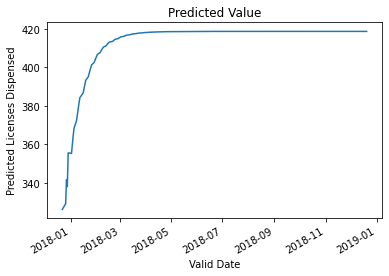

In [ ]:
fig = year_one['Predicted Value'].plot()
fig.set_title('Predicted Value')
fig.set_xlabel('Valid Date')
fig.set_ylabel('Predicted Licenses Dispensed')

In [ ]:
#There's a lot going on in the first 3 months, but after that it converges on itself
#I think that part of the issue here is that 251 steps is just too much for this kind of model
#I will still calculate the MSE, just out of curiosity

In [ ]:
#To keep it consistent, we will set all negative values to 0
year_one.loc[year_one['Predicted Value'] < 0] = 0

In [ ]:
df_18 = pd.read_csv('df_18_final.csv')
df_18 = df_18.set_index('ValidDate')

In [ ]:
mse = ((year_one['Predicted Value'] - df_18['Sum']) ** 2).mean()
print('The forecast MSE is {}'.format(round(mse, 2)))

The forecast MSE is 142611.59


# Conclusions/ Interpretation

Despite that scary looking graph, this actually performs better than our SARIMA forecast, which had an MSE of 145107.43. This model is not too shabby. And has the benefit that we didn't have to gridsearch for the best pdq like the SARIMA. It should definitely be used for a shorter amount of steps though, as it would seem the accuracy really starts to drop off as the model converges on itself.  
Some ideas for future work:  
* I would love to run a couple multivariate models and see if the categorical variables influence the forecast somehow.  
* As with most neural networks, you could spend weeks just tuning this. If there were more time, I would like to keep tweaking the final model and seeing just how low we can get the MSE. Even though this is the lowest one, it's still pretty high. 